# Modelling

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

# Introduction

Notebook to perform Modelling (sentiment analysis) on a reviews dataset of Amazon foods.

The dataset was sourced from [here](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data).

Previously we already cleaned and balanced the dataset, and determined that only about 10% of such dataset would be a able to use for Vectorization using the bag-of-words model.

In this notebook, we'll try to baseline some models, and try to determine which one is most suited for the sentiment analysis task.

## Import Custom Modules

In [1]:
import sys
sys.path

['/Users/rodrigo/anaconda3/envs/nlp_env/lib/python311.zip',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages']

In [2]:
sys.path.append('..')

In [3]:
from src.preprocessing import downsample_dataframe

In [4]:
from src.custom_tokenizer import tokenizer_and_lemma

## Import Libraries

In [5]:
import numpy as np
import pandas as pd

## Read Dataframe and Downsample

In [6]:
df = pd.read_csv('../data/reviews_clean_balanced.csv.gz',compression = 'gzip')

In [7]:
df.shape

(89262, 2)

In [8]:
df.head()

,Score,Text
0,0,My husband is originally from Germany and enjo...
1,0,I ordered this three times to be delivered to ...
2,0,We bought this as a low carb substitute for th...
3,0,If I could have given this product no stars I ...
4,0,I bought these chocolate frogs as part of a su...


In [9]:
# downsample to 10% of the dataframe
df_downsampled = downsample_dataframe(df,0.1)

In [10]:
df_downsampled.shape

(8925, 2)

## Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

X = df_downsampled['Text']
y = df_downsampled['Score'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,
                                                 random_state = 10,
                                                 stratify = y)

In [12]:
X_train.shape

(7140,)

### Instantiate Bag-of-words

Notice we're instantiating the bag of words count vectorizer now, on a separate step than the rest of the processing pipeline. This is intentional, as we want to use the same parameters for the CountVectorizer in both the training and test set.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# limit the document frequency to 10
# cap the max number of features to 500


bagofwords = CountVectorizer(tokenizer=tokenizer_and_lemma, min_df = 10, max_features = 500)

In [14]:
bagofwords.fit(X_train)

/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=500, min_df=10,
                tokenizer=<function tokenizer_and_lemma at 0x163a8bba0>)

In [15]:
X_train_transformed = bagofwords.transform(X_train)
X_train_transformed.shape

(7140, 500)

In [16]:
# vectorize the test data
X_test_transformed = bagofwords.transform(X_test)

# Define Processing Pipeline

Here we're just testing the processing pipeline, without optimizing any hyperparameters

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [18]:
# use a standard scaler
estimators = [('scaler',StandardScaler(with_mean = False)),
              ('logreg',LogisticRegression(random_state=10))]

# define a pipeline
pipe = Pipeline(estimators, verbose = True)

In [19]:
pipe.fit(X_train_transformed,y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg', LogisticRegression(random_state=10))],
         verbose=True)

In [20]:
train_score_pipe = pipe.score(X_train_transformed,y_train)

In [21]:
train_score_pipe

0.6857142857142857

In [22]:
#  check the test score
test_score_pipe = pipe.score(X_test_transformed,y_test)
test_score_pipe

0.5915966386554622

We see that there is a lower score for the test data, so we'll have to do some hyperparameter tunning to minimize overfitting.

## Save accuracy scores

In [23]:
from src.update_models_df import values_to_update, model_df

In [24]:
values = values_to_update()

In [25]:
values['model'] = "logistic regression"
values['train_score'] = train_score_pipe
values['test_score'] = test_score_pipe
values['num_features'] = 500
values['comments'] = 'no hyperparameter tuning'

In [26]:
model_df?

Signature: model_df(df, values_to_add)
Docstring:
To update dataframe keeping track of models. The dataframe will have the following columns:
    - model (str)
    - train_score (float)
    - test_score (float)
    - num_features (int)
    - comments (str)

Parameters
----------
df : DataFrame
    Pandas dataframe where we're appending the new values. Note, that if we don't have a dataframe yet, we only pass pd.Dataframe()

values_to_add : dictionary
    Up-to-date dictionary generated with `values_to_update()`

Returns
-------
DataFrame
    Up-to-date dataframe containing previous and newly added values.
File:      ~/Documents/Github/nlp_reviews/src/update_models_df.py
Type:      function

In [27]:
df_models = model_df(pd.DataFrame(),values)

In [28]:
df_models

,model,train_score,test_score,num_features,comments
0,logistic regression,0.685714,0.591597,500,no hyperparameter tuning


# Choosing regularization parameter C for Logistic Regression

Here, we're just going to check what happens when we change the regularization strength to the logistic regression model.

In [31]:
from tempfile import mkdtemp
# cached directory to speed up calculations
cachedir = mkdtemp()


all_Cvalues  = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
X_test_transformed = bagofwords.transform(X_test)

all_test_scores = []
all_train_scores = []

for Cvalue in all_Cvalues:    
    # same estimators as before
    estimators = [('scaler',StandardScaler(with_mean = False)),
                  ('logreg',LogisticRegression(random_state=10,C = Cvalue))
                 ]
    # pipeline
    pipe = Pipeline(estimators, verbose = True, memory = cachedir)

    pipe.fit(X_train_transformed,y_train)
    train_score_pipe = pipe.score(X_train_transformed,y_train)
    test_score_pipe = pipe.score(X_test_transformed,y_test)

    all_train_scores.append(train_score_pipe)
    all_test_scores.append(test_score_pipe)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s


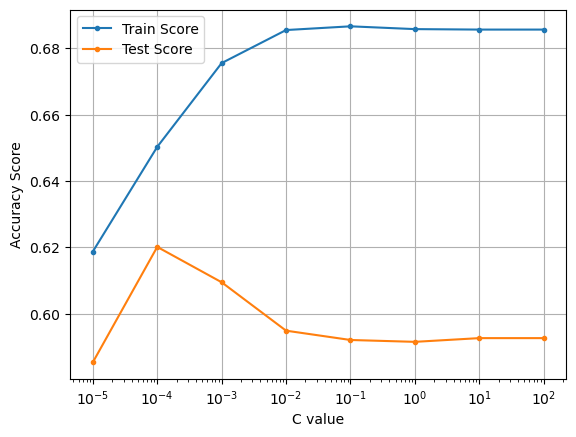

In [32]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(all_Cvalues,all_train_scores,label = 'Train Score',marker = '.')
plt.plot(all_Cvalues,all_test_scores,label = 'Test Score', marker = '.')

plt.xlabel('C value')
plt.ylabel('Accuracy Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

We see that a C value of 10^-4 gives us the highest test accuracy with a train accuracy of 0.65

# Further Actions

- We need to re-train the base model with the best parameters and further define thi classification report and confusion matrix. This will give us a senese of how well the reviews are classified.
- Since the accuracy score is low, we'll need to chooese a more comple model, perhaps random-forest based, or ensemble based.
- Other models to try are TFID, and neural network based models.